# SLO Clone - EL34 Bias Calculator

⚠️ **CRITICAL SAFETY WARNING** ⚠️

This calculator is for working with **HIGH VOLTAGE** tube amplifiers. Voltages exceeding 500V DC are present and can be **LETHAL**.

- Only proceed if you are qualified and experienced with tube amp maintenance
- Always discharge filter capacitors before working inside the amp
- Use one hand when probing (keep other hand in pocket)
- Read the [BIASING_GUIDE.md](BIASING_GUIDE.md) before proceeding

## How the SLO 100 Bias Circuit Works (per schematic)

The SLO 100 bias measurement circuit:
- The 4 power tubes (V6.1, V7.1, V8.1, V9.1) are arranged in **2 pairs**
- Each pair's cathodes are tied together and connected to ground through a **single 1Ω resistor**
  - **Top pair** (V6.1 + V7.1) → through R49 (1Ω) → Test point J12
  - **Bottom pair** (V8.1 + V9.1) → through R50 (1Ω) → Test point J11
- Each test point measures the **TOTAL current for BOTH tubes** in that pair
- You take **2 readings** (one at each test point) and divide by 2 to get per-tube current

This notebook provides interactive tools for calculating bias current and plate dissipation for paired EL34 tubes.

## Import Required Libraries

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

# Optional: ipywidgets for interactive interface (uncomment if you want to use widgets)
# !pip install ipywidgets
# from ipywidgets import interact, FloatSlider, IntSlider, Layout

## EL34BiasCalculator Class

This class handles all bias calculations for EL34 tubes, including:
- Converting bias voltage readings to current (for paired tubes)
- Calculating plate dissipation per tube
- Assessing whether bias is in safe operating range
- Providing recommendations for adjustment

**Important:** Per the schematic, each test point (J12, J11) measures the TOTAL current for both tubes in the pair through a single 1Ω resistor (R49, R50). The calculator divides by 2 to get per-tube values.

In [133]:
class EL34BiasCalculator:
    """Calculator for EL34 tube bias settings"""
    
    # EL34 Specifications
    MAX_DISSIPATION = 25.0  # Watts
    MIN_SAFE_PERCENT = 60.0  # Minimum safe operating percentage
    MAX_SAFE_PERCENT = 75.0  # Maximum safe operating percentage
    OPTIMAL_PERCENT = 70.0   # Recommended sweet spot
    
    # Common bias resistor value
    BIAS_RESISTOR = 1.0  # Ohms
    
    def __init__(self):
        self.plate_voltage = 0.0
        self.bias_readings = {}
        
    def calculate_current_from_voltage(self, voltage_mv, resistor_ohms=BIAS_RESISTOR):
        """
        Calculate bias current from voltage reading across bias resistor.
        
        Args:
            voltage_mv: Voltage reading in millivolts
            resistor_ohms: Bias resistor value (default 1Ω)
            
        Returns:
            Current in milliamps
        """
        # Ohm's Law: I = V / R
        # Convert mV to V, then to mA
        voltage_v = voltage_mv / 1000.0
        current_a = voltage_v / resistor_ohms
        current_ma = current_a * 1000.0
        return current_ma
    
    def calculate_plate_dissipation(self, plate_voltage, bias_current_ma):
        """
        Calculate plate dissipation.
        
        Args:
            plate_voltage: Plate voltage in volts
            bias_current_ma: Bias current in milliamps
            
        Returns:
            Plate dissipation in watts
        """
        # P = V × I
        current_a = bias_current_ma / 1000.0
        dissipation_w = plate_voltage * current_a
        return dissipation_w
    
    def get_dissipation_percentage(self, dissipation_w):
        """Calculate percentage of maximum dissipation"""
        return (dissipation_w / self.MAX_DISSIPATION) * 100.0
    
    def assess_bias(self, dissipation_percent):
        """
        Assess if bias is in safe range.
        
        Returns:
            tuple: (status, message, recommendation)
        """
        if dissipation_percent < self.MIN_SAFE_PERCENT:
            return ("COLD", "⚠️  TOO COLD", "Increase bias - tube is underbiased")
        elif dissipation_percent <= self.MAX_SAFE_PERCENT:
            if abs(dissipation_percent - self.OPTIMAL_PERCENT) <= 5:
                return ("OPTIMAL", "✓ OPTIMAL", "Perfect! No adjustment needed")
            elif dissipation_percent < self.OPTIMAL_PERCENT:
                return ("GOOD", "✓ GOOD (slightly cool)", "Acceptable, can increase slightly for more warmth")
            else:
                return ("GOOD", "✓ GOOD (slightly warm)", "Acceptable, can decrease slightly for more headroom")
        else:
            return ("HOT", "⚠️  TOO HOT - DANGER", "DECREASE BIAS IMMEDIATELY - Risk of tube damage!")
    
    def analyze_tube_pair(self, pair_name, voltage_mv, plate_voltage):
        """
        Analyze a tube pair based on test point reading.
        
        Per the schematic: Each test point measures the TOTAL current for both tubes
        in the pair through a single 1Ω resistor (R49 or R50).
        
        Returns dict with analysis for the pair and per-tube values.
        """
        # Total current for BOTH tubes (mV = mA with 1Ω resistor)
        total_current_ma = self.calculate_current_from_voltage(voltage_mv)
        
        # Current per individual tube (divide by 2)
        current_per_tube_ma = total_current_ma / 2.0
        
        # Dissipation per tube
        dissipation_per_tube_w = self.calculate_plate_dissipation(plate_voltage, current_per_tube_ma)
        dissipation_percent = self.get_dissipation_percentage(dissipation_per_tube_w)
        
        # Assess the bias
        status, message, recommendation = self.assess_bias(dissipation_percent)
        
        return {
            'pair_name': pair_name,
            'voltage_mv': voltage_mv,
            'plate_voltage': plate_voltage,
            'total_current_ma': total_current_ma,
            'current_per_tube_ma': current_per_tube_ma,
            'dissipation_per_tube_w': dissipation_per_tube_w,
            'dissipation_percent': dissipation_percent,
            'status': status,
            'message': message,
            'recommendation': recommendation
        }
    
    def print_pair_analysis(self, result):
        """Print detailed analysis for one tube pair"""
        print(f"\n{'='*60}")
        print(f"TEST POINT: {result['pair_name']}")
        print(f"{'='*60}")
        
        print(f"\nMeasurements:")
        print(f"  Bias Voltage Reading:  {result['voltage_mv']:.1f} mV (total for pair)")
        print(f"  Plate Voltage:         {result['plate_voltage']:.1f} V")
        
        print(f"\nCalculated Values:")
        print(f"  Total Pair Current:    {result['total_current_ma']:.2f} mA")
        print(f"  Current per Tube:      {result['current_per_tube_ma']:.2f} mA")
        print(f"  Dissipation per Tube:  {result['dissipation_per_tube_w']:.2f} W")
        print(f"  Dissipation %:         {result['dissipation_percent']:.1f}% of {self.MAX_DISSIPATION}W max")
        
        print(f"\nStatus: {result['message']}")
        print(f"Recommendation: {result['recommendation']}")
        
        self._print_dissipation_bar(result['dissipation_percent'])
    
    def _print_dissipation_bar(self, percent):
        """Print a visual bar showing dissipation level"""
        print(f"\nDissipation Range:")
        bar_length = 50
        filled = int((percent / 100.0) * bar_length)
        
        # Create markers for safe zones
        min_marker = int((self.MIN_SAFE_PERCENT / 100.0) * bar_length)
        opt_marker = int((self.OPTIMAL_PERCENT / 100.0) * bar_length)
        max_marker = int((self.MAX_SAFE_PERCENT / 100.0) * bar_length)
        
        bar = ""
        for i in range(bar_length):
            if i < filled:
                if i < min_marker:
                    bar += "░"  # Too cold
                elif i <= max_marker:
                    bar += "█"  # Safe zone
                else:
                    bar += "▓"  # Too hot
            else:
                bar += "·"
        
        print(f"  0% [{bar}] 100%")
        print(f"     ↑{' '*(min_marker-1)}↑{' '*(opt_marker-min_marker-1)}↑{' '*(max_marker-opt_marker-1)}↑")
        print(f"     60%{' '*(opt_marker-min_marker-2)}70%{' '*(max_marker-opt_marker-2)}75%")

In [134]:
def calculate_target_bias(plate_voltage, target_percent=70):
    """
    Calculate target bias reading for a given plate voltage.
    
    Args:
        plate_voltage: Measured plate voltage in volts
        target_percent: Target dissipation percentage (default 70% for optimal)
    
    Returns:
        Dictionary with target values
    """
    # Calculate target dissipation per tube
    target_dissipation_w = (target_percent / 100.0) * calculator.MAX_DISSIPATION
    
    # Calculate required current per tube: I = P / V
    target_current_per_tube_ma = (target_dissipation_w / plate_voltage) * 1000
    
    # Total current for BOTH tubes through the 1Ω resistor
    target_pair_current_ma = target_current_per_tube_ma * 2
    
    # Voltage reading across 1Ω resistor (V = I × R)
    # The test point measures BOTH tubes in the pair
    target_reading_mv = target_pair_current_ma  # Since R = 1Ω, mV = mA
    
    return {
        'plate_voltage': plate_voltage,
        'target_percent': target_percent,
        'target_dissipation_per_tube_w': target_dissipation_w,
        'target_current_per_tube_ma': target_current_per_tube_ma,
        'target_pair_current_ma': target_pair_current_ma,
        'target_reading_mv': target_reading_mv
    }

def print_adjustment_table(plate_voltage):
    """
    Print a detailed table showing target mV readings for different dissipation percentages.
    Use this while adjusting your bias pot to see what percentage you're at.
    """
    print(f"\n{'='*70}")
    print(f"🎯 BIAS ADJUSTMENT GUIDE - {plate_voltage}V PLATE VOLTAGE")
    print(f"{'='*70}")
    print("\nUse this table while turning your bias pot:")
    print("Match your mV reading to see what dissipation % you're at\n")
    print("NOTE: Each reading is for BOTH tubes in the pair (total current)\n")
    
    # Create table header
    print(f"{'Dissipation %':<18} {'Target mV':<15} {'mA/Tube':<15} {'Status':<20}")
    print("-" * 70)
    
    # Define percentage ranges to show
    percentages = [55, 60, 65, 70, 75, 80, 85]
    
    for percent in percentages:
        target = calculate_target_bias(plate_voltage, percent)
        mv = target['target_reading_mv']
        ma = target['target_current_per_tube_ma']
        
        # Status indicator
        if percent < 60:
            status = "❄️  TOO COLD"
            color_mark = ""
        elif 60 <= percent < 65:
            status = "🔵 Cool (Safe)"
            color_mark = ""
        elif 65 <= percent <= 75:
            if abs(percent - 70) <= 2:
                status = "✅ OPTIMAL"
                color_mark = " ⭐"
            else:
                status = "✓ Good (Safe)"
                color_mark = ""
        elif 75 < percent <= 80:
            status = "🟠 WARM - Caution"
            color_mark = ""
        else:
            status = "🔴 TOO HOT!"
            color_mark = ""
        
        print(f"{percent:>6}%{color_mark:<11} {mv:>7.1f} mV{'':<6} {ma:>6.1f} mA{'':<6} {status}")
    
    # Highlight optimal zone
    optimal = calculate_target_bias(plate_voltage, 70)
    print("\n" + "="*70)
    print(f"🎯 RECOMMENDED TARGET: {optimal['target_reading_mv']:.1f} mV per test point")
    print(f"   (This is {optimal['target_current_per_tube_ma']:.1f}mA per tube × 2 tubes)")
    print(f"   Safe Range: {calculate_target_bias(plate_voltage, 60)['target_reading_mv']:.1f} - "
          f"{calculate_target_bias(plate_voltage, 75)['target_reading_mv']:.1f} mV (60-75%)")
    print("="*70)
    
    print("\n📝 How to use:")
    print("   1. Warm up your amp for 2-3 minutes")
    print("   2. Measure your current mV reading at each test point")
    print("   3. Find it in the table above to see your current dissipation %")
    print("   4. Adjust bias pot to reach target mV reading")
    print("   5. Clockwise = more bias (higher mV), Counter-clockwise = less bias (lower mV)")
    print("\n📌 Remember: The mV reading = total current for BOTH tubes in that pair")
    
    return optimal

## Create Calculator Instance

In [135]:
calculator = EL34BiasCalculator()

print("="*60)
print("  SLO CLONE - EL34 BIAS CALCULATOR")
print("="*60)
print("\n⚠️  WARNING: Working with tube amps involves LETHAL VOLTAGES!")
print("Only proceed if you are qualified and have read the safety guide.")
print("\nCalculator ready! ✓")

  SLO CLONE - EL34 BIAS CALCULATOR

⚠️  WARNING: Working with tube amps involves LETHAL VOLTAGES!
Only proceed if you are qualified and have read the safety guide.

Calculator ready! ✓


## Target Bias Calculator

Enter your measured plate voltage below, and this will calculate the **exact mV reading** you should target for optimal bias (70% dissipation per tube).

## Enter Your Measurements

Modify the values below with your actual measurements:

**Important:** Each test point reading is the TOTAL current for both tubes in that pair!

In [136]:
import csv
from collections import defaultdict

def _load_bias_csv(path):
    with open(path, newline='') as f:
        rows = list(csv.DictReader(f))

    # Normalize numeric fields we care about
    for r in rows:
        for k in [
            'pin3_plate_anode_value',
            'pin4_screen_g2_value',
            'pin5_control_grid_g1_value',
            'pin8_cathode_value',
        ]:
            r[k] = float(r[k])
    return rows


def summarize_bias_extremes(high_csv='docs/bias high measurement.csv', low_csv='docs/bias low measurement.csv'):
    high = _load_bias_csv(high_csv)
    low = _load_bias_csv(low_csv)

    print("=" * 70)
    print("CSV BIAS EXTREMES SUMMARY")
    print("=" * 70)

    # Grid range check
    low_grid = {r['tube_name']: r['pin5_control_grid_g1_value'] for r in low}
    high_grid = {r['tube_name']: r['pin5_control_grid_g1_value'] for r in high}

    # Use averages (tubes in a pair will match closely)
    low_grid_avg = sum(low_grid.values()) / len(low_grid)
    high_grid_avg = sum(high_grid.values()) / len(high_grid)

    print(f"Grid (pin 5) at COLD end (avg): {low_grid_avg:.2f} V")
    print(f"Grid (pin 5) at HOT end  (avg): {high_grid_avg:.2f} V")
    print(f"Grid sweep (cold → hot):         {low_grid_avg - high_grid_avg:.2f} V")

    # Group the HOT data by the shared pin8 reading (pair reading)
    groups = defaultdict(list)
    for r in high:
        groups[r['pin8_cathode_value']].append(r)

    print("\nHOT-END PAIR RESULTS (pin 8 treated as *pair* mV):")
    print("-" * 70)

    for pair_mv, tubes in sorted(groups.items(), key=lambda x: x[0]):
        tube_names = ', '.join([t['tube_name'] for t in tubes])
        plate_v = sum([t['pin3_plate_anode_value'] for t in tubes]) / len(tubes)

        pair_current_ma = pair_mv  # 1Ω → mV == mA (pair total)
        per_tube_ma = pair_current_ma / 2.0
        diss_w = plate_v * (per_tube_ma / 1000.0)
        diss_pct = (diss_w / calculator.MAX_DISSIPATION) * 100.0

        print(f"Tubes: {tube_names}")
        print(f"  Plate V (avg):        {plate_v:.1f} V")
        print(f"  Pair reading:         {pair_mv:.1f} mV  (~{pair_current_ma:.1f} mA total)")
        print(f"  Per-tube current:     {per_tube_ma:.2f} mA")
        print(f"  Dissipation (est):    {diss_w:.2f} W/tube")
        print(f"  Dissipation (est):    {diss_pct:.1f}% of 25W")

    print("\nNote: This uses cathode current as a proxy for plate current, so the")
    print("computed dissipation is a conservative estimate (actual plate dissipation")
    print("is usually a bit lower because some current is screen current).")


# Run the summary
summarize_bias_extremes()

CSV BIAS EXTREMES SUMMARY
Grid (pin 5) at COLD end (avg): -67.15 V
Grid (pin 5) at HOT end  (avg): -40.83 V
Grid sweep (cold → hot):         -26.32 V

HOT-END PAIR RESULTS (pin 8 treated as *pair* mV):
----------------------------------------------------------------------
Tubes: EL34_1, EL34_2
  Plate V (avg):        486.6 V
  Pair reading:         64.3 mV  (~64.3 mA total)
  Per-tube current:     32.15 mA
  Dissipation (est):    15.64 W/tube
  Dissipation (est):    62.6% of 25W
Tubes: EL34_3, EL34_4
  Plate V (avg):        488.5 V
  Pair reading:         68.3 mV  (~68.3 mA total)
  Per-tube current:     34.15 mA
  Dissipation (est):    16.68 W/tube
  Dissipation (est):    66.7% of 25W

Note: This uses cathode current as a proxy for plate current, so the
computed dissipation is a conservative estimate (actual plate dissipation
is usually a bit lower because some current is screen current).


In [137]:
# ===== ENTER YOUR MEASUREMENTS HERE =====

# Your plate voltage (typically 450-500V)
my_plate_voltage = 486

# Your bias readings in mV (one per test point)
# Each reading is the TOTAL current for both tubes in that pair
my_pair_readings = {
    'Test Point J12 (V6+V7)': 71,  # mV reading for top pair (both tubes)
    'Test Point J11 (V8+V9)': 76   # mV reading for bottom pair (both tubes)
}

# ========================================

# Analyze your bias readings
print("Analyzing YOUR bias readings...\n")
print("Note: Each reading is total for BOTH tubes in the pair")
print("Calculator will divide by 2 to show per-tube values\n")

my_results = []
for pair_name, bias_mv in my_pair_readings.items():
    result = calculator.analyze_tube_pair(pair_name, bias_mv, my_plate_voltage)
    calculator.print_pair_analysis(result)
    my_results.append(result)

# Summary
print(f"\n{'='*60}")
print("YOUR SUMMARY")
print(f"{'='*60}")

my_per_tube_currents = [r['current_per_tube_ma'] for r in my_results]
my_avg = sum(my_per_tube_currents) / len(my_per_tube_currents)
my_diff = max(my_per_tube_currents) - min(my_per_tube_currents)

print(f"\nAverage Current per Tube:     {my_avg:.2f} mA")
print(f"Current Difference (pairs):   {my_diff:.2f} mA")

if my_diff > 3:
    print("\n⚠️  NOTE: Difference between pairs is >3mA per tube")
else:
    print("\n✓ Good matching between pairs")

if all(r['status'] in ['GOOD', 'OPTIMAL'] for r in my_results):
    print("\n✓ All tubes properly biased!")
else:
    print("\n⚠️  Adjustment needed - see recommendations above")

Analyzing YOUR bias readings...

Note: Each reading is total for BOTH tubes in the pair
Calculator will divide by 2 to show per-tube values


TEST POINT: Test Point J12 (V6+V7)

Measurements:
  Bias Voltage Reading:  71.0 mV (total for pair)
  Plate Voltage:         486.0 V

Calculated Values:
  Total Pair Current:    71.00 mA
  Current per Tube:      35.50 mA
  Dissipation per Tube:  17.25 W
  Dissipation %:         69.0% of 25.0W max

Status: ✓ OPTIMAL
Recommendation: Perfect! No adjustment needed

Dissipation Range:
  0% [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░████················] 100%
     ↑                             ↑    ↑ ↑
     60%   70%75%

TEST POINT: Test Point J11 (V8+V9)

Measurements:
  Bias Voltage Reading:  76.0 mV (total for pair)
  Plate Voltage:         486.0 V

Calculated Values:
  Total Pair Current:    76.00 mA
  Current per Tube:      38.00 mA
  Dissipation per Tube:  18.47 W
  Dissipation %:         73.9% of 25.0W max

Status: ✓ OPTIMAL
Recommendation: Perfect! No adju

In [138]:
def diagnose_low_bias(current_mv, target_mv, plate_voltage):
    """
    Diagnose why bias reading is lower than target and can't be increased.
    """
    print(f"\n{'='*70}")
    print("🔧 BIAS TROUBLESHOOTING DIAGNOSTIC")
    print(f"{'='*70}\n")
    
    print(f"Current Reading:  {current_mv:.1f} mV")
    print(f"Target Reading:   {target_mv:.1f} mV")
    print(f"Shortfall:        {target_mv - current_mv:.1f} mV ({((target_mv - current_mv) / target_mv * 100):.1f}% below target)")
    print(f"Plate Voltage:    {plate_voltage:.0f} V\n")
    
    current_per_tube = current_mv / 2.0
    target_per_tube = target_mv / 2.0
    
    print("="*70)
    print("POSSIBLE CAUSES (in order of likelihood):")
    print("="*70)
    
    print("\n1. 🔋 WEAK OR OLD TUBES (Most Common)")
    print("   - Tubes lose emission over time and can't draw rated current")
    print("   - Even 'new' tubes can be weak if they've been sitting on shelf")
    print(f"   - Your tubes are drawing {current_per_tube:.1f}mA each (need {target_per_tube:.1f}mA)")
    print("   ✓ SOLUTION: Replace with fresh, matched set of EL34s")
    print("   - Test: Try known-good tubes to see if bias increases")
    
    print("\n2. 🎛️  BIAS POT AT LIMIT")
    print("   - Bias pot may not have enough range")
    print("   - Common if wrong value pot was installed during mod/repair")
    print("   ✓ SOLUTION: Check bias pot value (should be 100k-220k typically)")
    print("   ✓ SOLUTION: May need to adjust bias supply voltage (advanced)")
    
    print("\n3. ⚡ BIAS SUPPLY VOLTAGE LOW")
    print("   - Negative bias voltage may be insufficient")
    print("   - Could be failing components in bias supply")
    print("   ✓ CHECK: Measure bias supply voltage (typically -40V to -60V)")
    print("   ✓ SOLUTION: Check bias supply capacitors and resistors")
    
    print("\n4. 🔌 TUBE SOCKET ISSUES")
    print("   - Dirty or oxidized tube socket contacts")
    print("   - Poor connection increases resistance")
    print("   ✓ SOLUTION: Clean tube sockets with contact cleaner")
    print("   ✓ SOLUTION: Check for loose or corroded pins")
    
    print("\n5. 🔥 HIGH PLATE VOLTAGE")
    if plate_voltage > 500:
        print(f"   ⚠️  Your plate voltage ({plate_voltage}V) is HIGH")
        print("   - Higher plate voltage requires more bias current")
        print("   - May be difficult to reach target with weak tubes")
        print("   ✓ CHECK: Verify mains voltage isn't too high")
    else:
        print(f"   - Your plate voltage ({plate_voltage}V) is in normal range")
        print("   - This is probably not the issue")
    
    print("\n6. ⚙️  INCORRECT CATHODE RESISTOR VALUES")
    print("   - Check R49/R50 are actually 1Ω (not 10Ω or other value)")
    print("   - Wrong value will give incorrect readings")
    print("   ✓ CHECK: Measure resistor values with ohmmeter (power off!)")
    
    print("\n" + "="*70)
    print("RECOMMENDED ACTION PLAN:")
    print("="*70)
    
    shortfall_percent = (target_mv - current_mv) / target_mv * 100
    
    if shortfall_percent > 30:
        print("\n⚠️  You're MORE than 30% below target - Likely WEAK TUBES")
        print("   1. Replace with a fresh matched quad of EL34s")
        print("   2. If new tubes don't help, check bias supply voltage")
        print("   3. Clean tube sockets before installing new tubes")
    elif shortfall_percent > 15:
        print("\n📋 You're 15-30% below target - Could be:")
        print("   1. Aging tubes (replace if >6 months old with regular use)")
        print("   2. Bias pot at its limit (measure pot resistance)")
        print("   3. Dirty tube sockets (clean first, cheap fix)")
    else:
        print("\n✓ You're within 15% - This may be acceptable")
        print("   - Some amps run slightly cool by design")
        print("   - Check if bias pot has more travel")
        print("   - Consider if tubes are matched set")
    
    print("\n💡 SAFETY NOTE:")
    print("   - Running cool (below 70%) is SAFER than running hot")
    print("   - 55-65% dissipation will give longer tube life")
    print("   - You'll lose some power and tone warmth, but won't damage anything")
    
    return

# Run diagnostic if you're having trouble reaching target
# Uncomment and modify these values:

# your_current_reading = 56.5  # Your actual mV reading
# your_target = optimal_target['target_reading_mv']  # From the target calculator above
# diagnose_low_bias(your_current_reading, your_target, my_plate_voltage)

In [139]:
# Display the adjustment table
optimal_target = print_adjustment_table(my_plate_voltage)


🎯 BIAS ADJUSTMENT GUIDE - 486V PLATE VOLTAGE

Use this table while turning your bias pot:
Match your mV reading to see what dissipation % you're at

NOTE: Each reading is for BOTH tubes in the pair (total current)

Dissipation %      Target mV       mA/Tube         Status              
----------------------------------------------------------------------
    55%               56.6 mV         28.3 mA       ❄️  TOO COLD
    60%               61.7 mV         30.9 mA       🔵 Cool (Safe)
    65%               66.9 mV         33.4 mA       ✓ Good (Safe)
    70% ⭐             72.0 mV         36.0 mA       ✅ OPTIMAL
    75%               77.2 mV         38.6 mA       ✓ Good (Safe)
    80%               82.3 mV         41.2 mA       🟠 WARM - Caution
    85%               87.4 mV         43.7 mA       🔴 TOO HOT!

🎯 RECOMMENDED TARGET: 72.0 mV per test point
   (This is 36.0mA per tube × 2 tubes)
   Safe Range: 61.7 - 77.2 mV (60-75%)

📝 How to use:
   1. Warm up your amp for 2-3 minutes
   2. 

## Visualize Bias Range

Let's create a visual chart showing the safe operating zones and where your tubes fall:

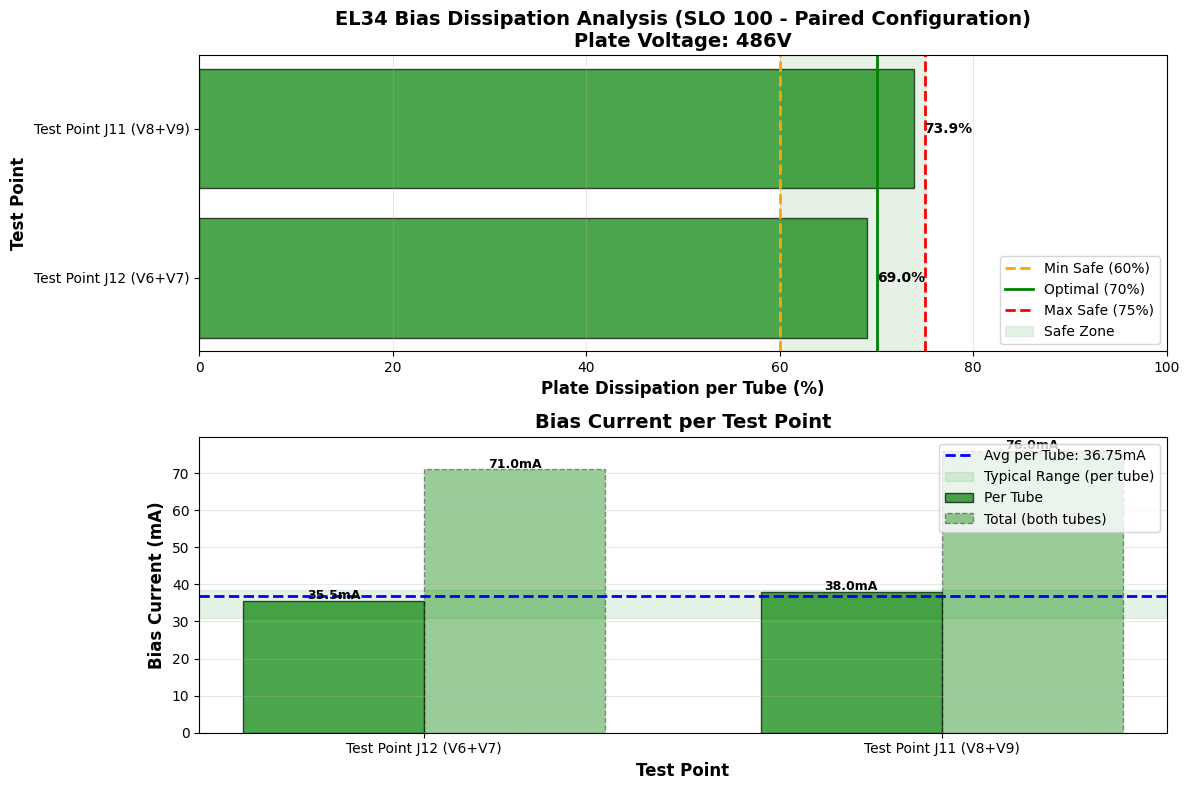


VISUAL ANALYSIS SUMMARY
Average Current per Tube: 36.75mA
Per-tube Range: 35.50mA - 38.00mA
Difference: 2.50mA
Target Range: 30.9mA - 38.6mA (60-75% dissipation per tube)


In [140]:
def plot_bias_range(results, plate_voltage):
    """Create a visual plot of bias ranges and current tube pair readings"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Dissipation percentage bar chart
    pair_names = [r['pair_name'] for r in results]
    dissipations = [r['dissipation_percent'] for r in results]
    
    # Color code based on status
    colors = []
    for r in results:
        if r['status'] == 'OPTIMAL':
            colors.append('green')
        elif r['status'] == 'GOOD':
            colors.append('yellowgreen')
        elif r['status'] == 'COLD':
            colors.append('blue')
        else:
            colors.append('red')
    
    bars = ax1.barh(pair_names, dissipations, color=colors, alpha=0.7, edgecolor='black')
    
    # Add reference lines
    ax1.axvline(x=60, color='orange', linestyle='--', linewidth=2, label='Min Safe (60%)')
    ax1.axvline(x=70, color='green', linestyle='-', linewidth=2, label='Optimal (70%)')
    ax1.axvline(x=75, color='red', linestyle='--', linewidth=2, label='Max Safe (75%)')
    
    # Shade safe zone
    ax1.axvspan(60, 75, alpha=0.1, color='green', label='Safe Zone')
    
    ax1.set_xlabel('Plate Dissipation per Tube (%)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Test Point', fontsize=12, fontweight='bold')
    ax1.set_title(f'EL34 Bias Dissipation Analysis (SLO 100 - Paired Configuration)\nPlate Voltage: {plate_voltage}V', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 100)
    ax1.legend(loc='lower right')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add percentage labels on bars
    for i, (bar, pct) in enumerate(zip(bars, dissipations)):
        ax1.text(pct + 1, bar.get_y() + bar.get_height()/2, 
                f'{pct:.1f}%', va='center', fontweight='bold')
    
    # Plot 2: Bias current comparison (per tube)
    per_tube_currents = [r['current_per_tube_ma'] for r in results]
    total_currents = [r['total_current_ma'] for r in results]
    
    x = np.arange(len(pair_names))
    width = 0.35
    
    bars2a = ax2.bar(x - width/2, per_tube_currents, width, label='Per Tube', 
                     color=colors, alpha=0.7, edgecolor='black')
    bars2b = ax2.bar(x + width/2, total_currents, width, label='Total (both tubes)', 
                     color=colors, alpha=0.4, edgecolor='black', linestyle='--')
    
    # Add average line (per tube)
    avg_current = sum(per_tube_currents) / len(per_tube_currents)
    ax2.axhline(y=avg_current, color='blue', linestyle='--', linewidth=2, 
                label=f'Avg per Tube: {avg_current:.2f}mA')
    
    # Calculate typical range for plate voltage
    typical_min = (15 / plate_voltage) * 1000  # 15W @ plate voltage
    typical_max = (18.75 / plate_voltage) * 1000  # 18.75W @ plate voltage
    ax2.axhspan(typical_min, typical_max, alpha=0.1, color='green', label='Typical Range (per tube)')
    
    ax2.set_xlabel('Test Point', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Bias Current (mA)', fontsize=12, fontweight='bold')
    ax2.set_title('Bias Current per Test Point', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(pair_names)
    ax2.legend(loc='upper right')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add current labels on bars
    for bar, current in zip(bars2a, per_tube_currents):
        ax2.text(bar.get_x() + bar.get_width()/2, current + 0.5, 
                f'{current:.1f}mA', ha='center', fontweight='bold', fontsize=9)
    
    for bar, current in zip(bars2b, total_currents):
        ax2.text(bar.get_x() + bar.get_width()/2, current + 0.5, 
                f'{current:.1f}mA', ha='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("VISUAL ANALYSIS SUMMARY")
    print("="*60)
    print(f"Average Current per Tube: {avg_current:.2f}mA")
    print(f"Per-tube Range: {min(per_tube_currents):.2f}mA - {max(per_tube_currents):.2f}mA")
    print(f"Difference: {max(per_tube_currents) - min(per_tube_currents):.2f}mA")
    print(f"Target Range: {typical_min:.1f}mA - {typical_max:.1f}mA (60-75% dissipation per tube)")

# Generate the plot with your results
plot_bias_range(my_results, my_plate_voltage)

## Quick Reference: Bias Formulas

Here are the key formulas used in these calculations:

### Ohm's Law (for current calculation)
$$I_{total} = \frac{V}{R}$$

$$I_{per\_tube} = \frac{I_{total}}{2}$$

Where:
- $I_{total}$ = Total current for both tubes in the pair (amps)
- $I_{per\_tube}$ = Current per individual tube (amps)
- $V$ = Voltage reading across 1Ω bias resistor (volts)
- $R$ = Resistance (1Ω)

### Power Dissipation (per tube)
$$P = V_{plate} \times I_{per\_tube}$$

Where:
- $P$ = Power dissipation per tube in watts
- $V_{plate}$ = Plate voltage in volts
- $I_{per\_tube}$ = Bias current per tube in amps

### Dissipation Percentage
$$\text{Dissipation \%} = \frac{P_{actual}}{P_{max}} \times 100$$

Where:
- $P_{actual}$ = Actual plate dissipation per tube
- $P_{max}$ = Maximum rated dissipation (25W for EL34)

### Target Values for EL34
- **Maximum Dissipation:** 25W per tube
- **Safe Range:** 60-75% (15W - 18.75W per tube)
- **Optimal:** 70% (~17.5W per tube)
- **Typical Plate Voltage:** 450-500V
- **Typical Bias Current:** 30-45mA **per tube**
- **Typical Test Point Reading:** 60-90mV (for both tubes in pair combined)

## Notes and Best Practices

1. **SLO 100 measures tube PAIRS**, not individual tubes - you'll only have 2 readings
2. **Always warm up the amp for 2-3 minutes** before taking bias readings
3. **Use matched tubes** for best performance and longer life
4. **Check bias regularly** - every 3-6 months or when changing tubes
5. **Pairs should be within 3-5mA per tube** of each other
6. **If readings are unstable**, tube may be failing or socket may need cleaning
7. **Never exceed 75% dissipation** - risk of tube damage and "red plating"
8. **Document your readings** with dates for maintenance tracking
9. Some SLO amps have **independent bias pots** for each pair, others have a single master bias control

**Stay safe and enjoy your tone!**